# Toy model analysis

Jupyter notebook for the analysis of radial updates in the context of the toy model.  
Naturally, utilizing this notebook requires access to the data and the path has to be provided in the next cell.  
While this notebook should suffice to recreate all the analysis steps starting from the raw data (i.e. the files given in "Rtoy/data"), actually running all of the postprocessing steps will take quite a lot of time. Therefore, the intermediate postprocessed data is already provided in "Rtoy/postpro_data".  

### Specifiy glob_path to link to the data folder

In [ ]:
glob_path = ""

data_path = glob_path + "Rtoy/data/"
postpro_path = glob_path + "Rtoy/postpro_data/"
plot_path = glob_path + "Rtoy/plots/"

### Import modules and necessary custom functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
%matplotlib inline

from utils import save_arrays, round_to_n_of_err, get_parentheses_error_notation
from Rtoy_funcs import get_Rtoy_autocorrelations, make_rtoy_ac_fits, get_tunneling_rate, Rtoy_dist_2D, get_margin_dist
from fitting import bootstrap_fit, smin_fit_f, logsmin_fit_f

my_blue, my_red, my_green = (2/255, 61/255, 107/255), (217/255, 85/255, 20/255), (163/255, 201/255, 0/255)
cs = [my_blue, my_red, my_green]

# Scatterplot for 2D model with fine MD

Load the data for the two example parameter choices $\sigma_R = 0$ (no radial updates) and $\sigma_R = 1.75$ (near optimal radial updates).

In [3]:
N_max = int(1e4)
n_skip = 1

path = data_path + "Rtoy_d2_sig0p0_NMD12_tMD1_wb0p125_N1e6.txt"
HMC_data = np.loadtxt(path, usecols = (0, 3), unpack = True, max_rows = N_max)
x0_HMC = HMC_data[1, ::n_skip]
x1_HMC = HMC_data[0, ::n_skip]*2-x0_HMC

path = data_path + "Rtoy_d2_sig1p75_NMD12_tMD1_wb0p125_N1e6.txt"
R_data = np.loadtxt(path, usecols = (0, 3), unpack = True, max_rows = N_max)
x0_R = R_data[1, ::n_skip]
x1_R = R_data[0, ::n_skip]*2-x0_R



Compute true two-dimensional density and marginal distribution for subsequent plotting. 

In [5]:
k = 2
lim = (2*k+1)*np.pi/2
dx = 0.01
x = y = np.arange(-lim, lim+dx, dx)
X, Y = np.meshgrid(x, y)
beta = 0.125
Z = Rtoy_dist_2D(X, Y, beta)
x_margin_dist, margin_dist = get_margin_dist(beta, lim = 10, dx = dx)


Make the scatterplot. The two previous cells have to be executed first. 

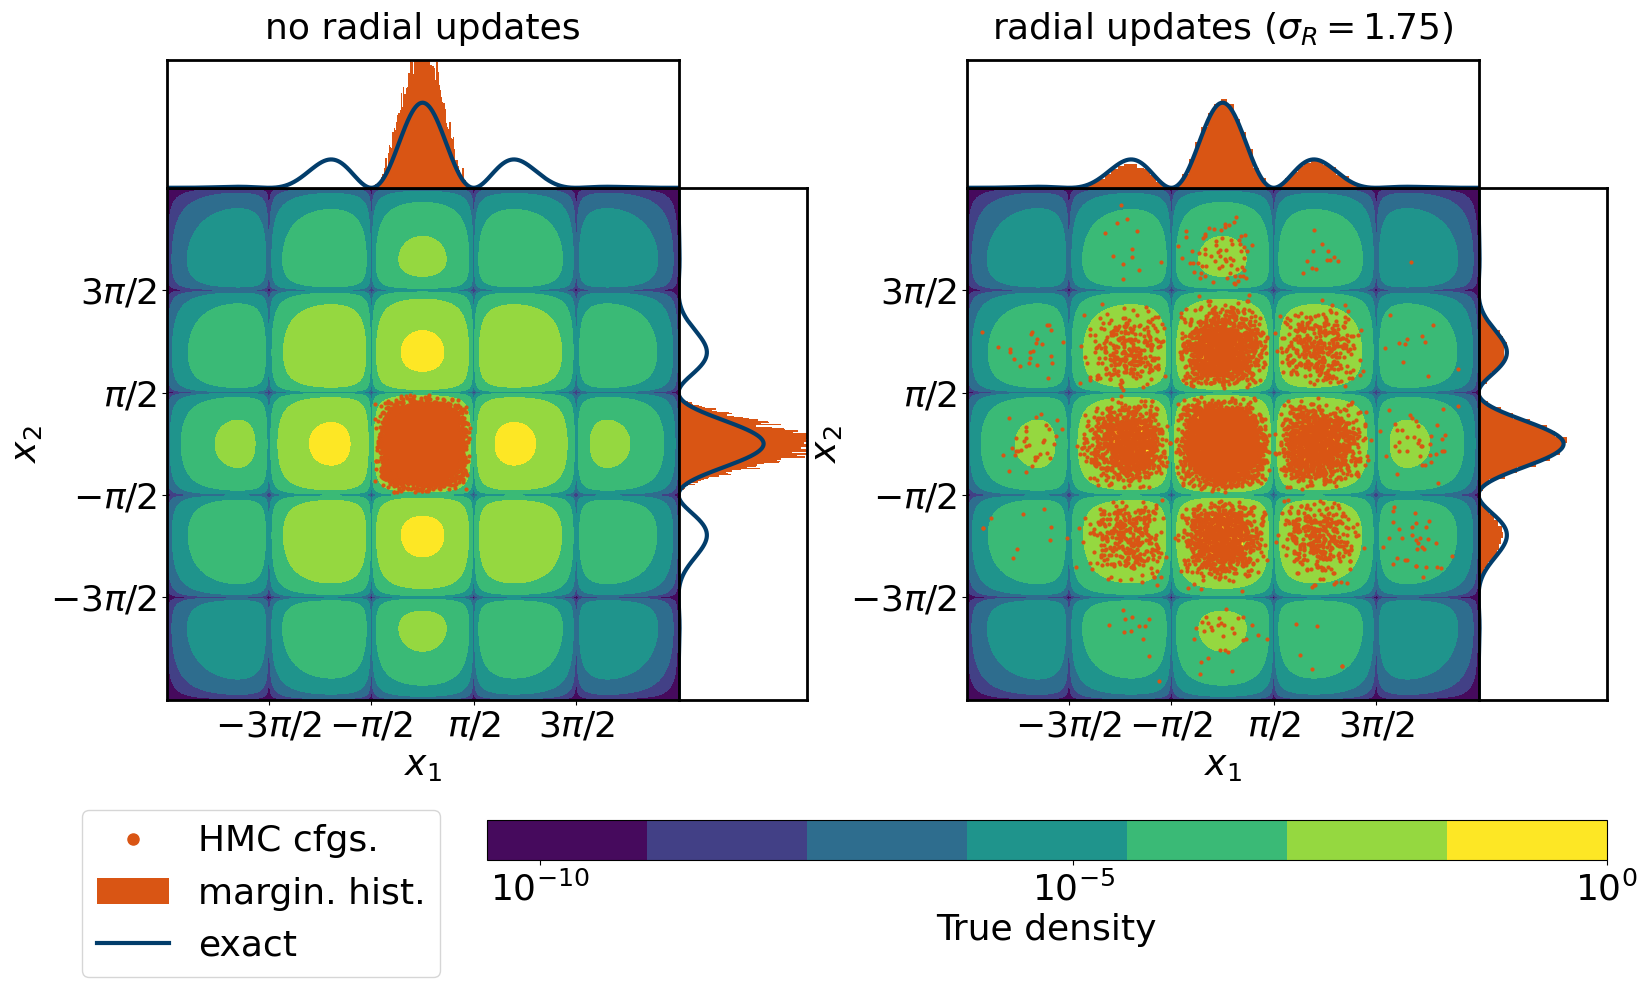

In [6]:
### Plot Settings
my_blue = (2/255, 61/255, 107/255)
my_red = (217/255, 85/255, 20/255)
my_green = (163/255, 201/255, 0/255)

fs = 26
lw = 3
Nt = 1
kappa = 1
beta = 1
U = 18

Nconf = 10000
bins = 80
bin_lim = 5

fig = plt.figure(figsize = (16, 8))
subfigs = fig.subfigures(1, 2, wspace = 0.2)

gs1 = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.0, hspace=0.0)
ax1 = subfigs[0].add_subplot(gs1[1,0], aspect = "equal")
ax1_hist_x = subfigs[0].add_subplot(gs1[0, 0], sharex = ax1) #
ax1_hist_y = subfigs[0].add_subplot(gs1[1, 1], sharey = ax1) #


plot_off = -10#1e-10

log10_Z = np.clip(np.log10(np.real(Z)), a_min = plot_off, a_max = None)
CS = ax1.contourf(X, Y, log10_Z, vmin = plot_off, vmax = np.amax(log10_Z))
for c in CS.collections:
    c.set_rasterized(True)

ax1_hist_x.hist(x0_HMC, density = True, color = my_red, alpha = 1., bins = bins, range = (-bin_lim, bin_lim), label = r"$\phi_1$")
ax1_hist_y.hist(x1_HMC, density = True, color = my_red, alpha = 1.0, bins = bins, range = (-bin_lim, bin_lim), label = r"$\phi_2$", orientation = "horizontal")
ax1_hist_x.plot(x_margin_dist, margin_dist, label = "exact", color = my_blue, linewidth = lw)
ax1_hist_y.plot(margin_dist, x_margin_dist, label = "exact", color = my_blue, linewidth = lw)
ax1.scatter(x0_HMC, x1_HMC, marker = "o", s = 4, color = cs[1])

ax1.plot([-30], [-30], marker = "o", color = my_red, markersize = 8, linestyle = "", label = "HMC cfgs.")
ax1.hist(x0_HMC[:10]-60, density = True, color = my_red, alpha = 1.0, bins = bins, rwidth = 0.5, label = r"margin. hist.", orientation = "horizontal")
ax1.plot([-30], [-30], marker = "", color = my_blue, markersize = 1, linestyle = "-", linewidth = lw, label = "exact")
ax1.legend(loc = "upper left", bbox_to_anchor = (-0.2, -0.18), fontsize = fs)
# ax1.legend(loc = "upper right", bbox_to_anchor = (3.615, 1.4), fontsize = fs)

gs2 = subfigs[1].add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.0, hspace=0.0)
ax2 = subfigs[1].add_subplot(gs2[1,0], aspect = "equal")
ax2_hist_x = subfigs[1].add_subplot(gs2[0, 0], sharex = ax2) #
ax2_hist_y = subfigs[1].add_subplot(gs2[1, 1], sharey = ax2) #

CS = ax2.contourf(X, Y, log10_Z, vmin = plot_off, vmax = np.amax(log10_Z))
for c in CS.collections:
    c.set_rasterized(True)

ax2_hist_x.hist(x0_R, density = True, color = my_red, alpha = 1., bins = bins, range = (-bin_lim, bin_lim), label = r"$\phi_1$")
ax2_hist_y.hist(x1_R, density = True, color = my_red, alpha = 1.0, bins = bins, range = (-bin_lim, bin_lim), label = r"$\phi_2$", orientation = "horizontal")
ax2_hist_x.plot(x_margin_dist, margin_dist, label = "exact", color = my_blue, linewidth = lw)
ax2_hist_y.plot(margin_dist, x_margin_dist, label = "exact", color = my_blue, linewidth = lw)
ax2.scatter(x0_R, x1_R, marker = "o", s = 4, color = cs[1])


ax1.set_xlim(-lim, lim), ax1.set_ylim(-lim, lim)
ax2.set_xlim(-lim, lim), ax2.set_ylim(-lim, lim)

temp = [-20, -10, 0, 10, 20]
# k_ = [-3, -2, -1, 0, 1, 2]
# man_temp_labels = [r"$-5\pi/2$           ", r"$-3\pi/2$", r"$-\pi/2$", r"$\pi/2$", r"$3\pi/2$"]
# man_temp_labels2 = [r"", r"$-3\pi/2$", r"$-\pi/2$", r"$\pi/2$", r"$3\pi/2$", r"$5\pi/2$"]
k_ = [-2, -1, 0, 1]
man_temp_labels = [r"$-3\pi/2$", r"$-\pi/2$", r"$\pi/2$", r"$3\pi/2$"]
man_temp_labels2 = [r"$-3\pi/2$", r"$-\pi/2$", r"$\pi/2$", r"$3\pi/2$"]

temp = np.add(np.multiply(k_, 2), 1)*np.pi/2
# man_temp_labels = [r"$-5\pi/2$           ", r"$-3\pi/2$", r"$-\pi/2$", r"$\pi/2$", r"$3\pi/2$", r"$5\pi/2$"]
temp2 = [0.0, 0.1, 0.2]

ax1_hist_x.tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
ax1_hist_y.tick_params(axis = "y", which = "both", left = False, top = False, labelleft = False)
ax1_hist_y.tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
ax1_hist_x.tick_params(axis = "y", which = "both", left = False, top = False, labelleft = False)

ax2_hist_x.tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
ax2_hist_y.tick_params(axis = "y", which = "both", left = False, top = False, labelleft = False)
ax2_hist_y.tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
ax2_hist_x.tick_params(axis = "y", which = "both", left = False, top = False, labelleft = False)

# ax1_hist_x.set_yticks(temp2, ["" for x in temp2], fontsize = fs)
# ax1_hist_y.set_xticks(temp2, ["" for x in temp2], fontsize = fs)

# ax2_hist_x.set_yticks(temp2, ["" for x in temp2], fontsize = fs)
# ax2_hist_y.set_xticks(temp2, ["" for x in temp2], fontsize = fs)

ax1.set_xticks(temp, man_temp_labels, fontsize = fs)
ax2.set_xticks(temp, man_temp_labels, fontsize = fs)
# man_temp_labels2 = [r"", r"$-3\pi/2$", r"$-\pi/2$", r"$\pi/2$", r"$3\pi/2$", r"$5\pi/2$"]
ax1.set_yticks(temp, man_temp_labels2, fontsize = fs)
ax2.set_yticks(temp, man_temp_labels2, fontsize = fs)

ax1.set_xlabel(r"$x_1$", fontsize = fs)
ax1.set_ylabel(r"$x_2$", fontsize = fs)
ax2.set_xlabel(r"$x_1$", fontsize = fs)
ax2.set_ylabel(r"$x_2$", fontsize = fs)

hist_ylim = 0.6
ax1_hist_x.set_ylim(0., hist_ylim), ax1_hist_y.set_xlim(0., hist_ylim)
ax2_hist_x.set_ylim(0., hist_ylim), ax2_hist_y.set_xlim(0., hist_ylim)
# ax1_hist_x.set_yscale("log"), ax1_hist_y.set_xscale("log")
# ax2_hist_x.set_yscale("log"), ax2_hist_y.set_xscale("log")
# hist_logybotlim, hist_logyuplim = 1e-5, 1

# ax1_hist_x.set_ylim(hist_logybotlim, hist_logyuplim), ax1_hist_y.set_xlim(hist_logybotlim, hist_logyuplim)
# ax2_hist_x.set_ylim(hist_logybotlim, hist_logyuplim), ax2_hist_y.set_xlim(hist_logybotlim, hist_logyuplim)

spinewidth = 2
for spine in ax1.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax1_hist_x.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax1_hist_y.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax2.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax2_hist_x.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax2_hist_y.spines.values():
    spine.set_linewidth(spinewidth)

ax1_hist_x.set_title("no radial updates", fontsize = fs, pad = 15)
ax2_hist_x.set_title(r"radial updates ($\sigma_R = 1.75$)", fontsize = fs, pad = 15)

# cbar_ax = fig.add_axes([1.0, 0.1, 0.03, 0.63])
# cbar = fig.colorbar(CS, cax=cbar_ax, orientation = "vertical")
# cbar.set_label("True density", size = fs)
# cbar.ax.tick_params(labelsize = fs, pad = 5)
# cbar.set_ticks([0, -5, -10], labels = [r"$10^{0}$", r"$10^{-5}$", r"$10^{-10}$"])


cbar_ax = fig.add_axes([0.25, -0.1, 0.7, 0.05])
cbar = fig.colorbar(CS, cax=cbar_ax, orientation = "horizontal", fraction = 0.05, pad = 0.1)
cbar.set_label("True density", size = fs)
cbar.ax.tick_params(labelsize = fs, pad = 5)
cbar.set_ticks([0, -5, -10], labels = [r"$10^{0}$", r"$10^{-5}$", r"$10^{-10}$"])

# plt.savefig(plot_path + "Rtoy_d2_scatter_margin.pdf", dpi = 600, bbox_inches = "tight")
plt.show()

# Information on all simulations

## The following dictionaries have to be initialized when running the analysis. 

Coarse MD integration simulations:

In [8]:
coarse_dict = {}

sig_ = [0.0, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0]
d1_coarse_dict = {"sig": sig_, "NMD" : 1, "tMD" : 1, "Nconf" : "1e6"}

sig_ = [0.0, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0]
d2_coarse_dict = {"sig": sig_, "NMD" : 2, "tMD" : 1, "Nconf" : "1e6"}

sig_ = [0.0, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
d4_coarse_dict = {"sig": sig_, "NMD" : 2, "tMD" : 1, "Nconf" : "1e6"}

sig_ = [0.0, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
d8_coarse_dict = {"sig": sig_, "NMD" : 3, "tMD" : 1, "Nconf" : "1e6"}

sig_ = [0.0, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0]
d16_coarse_dict = {"sig": sig_, "NMD" : 4, "tMD" : 1, "Nconf" : "1e6"}

sig_ = [0.0, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0]
d32_coarse_dict = {"sig": sig_, "NMD" : 5, "tMD" : 1, "Nconf" : "1e6"}

sig_ = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0]
d64_coarse_dict = {"sig": sig_, "NMD" : 7, "tMD" : 1, "Nconf" : "1e7"}

sig_ = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]
d96_coarse_dict = {"sig": sig_, "NMD" : 8, "tMD" : 1, "Nconf" : "1e7"}

sig_ = [0.0, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 1.5, 2.0, 3.0]
d128_coarse_dict = {"sig": sig_, "NMD" : 10, "tMD" : 1, "Nconf" : "1e7"}

coarse_dict["d1"] = d1_coarse_dict
coarse_dict["d2"] = d2_coarse_dict
coarse_dict["d4"] = d4_coarse_dict
coarse_dict["d8"] = d8_coarse_dict
coarse_dict["d16"] = d16_coarse_dict
coarse_dict["d32"] = d32_coarse_dict
coarse_dict["d64"] = d64_coarse_dict
coarse_dict["d96"] = d96_coarse_dict
coarse_dict["d128"] = d128_coarse_dict


Fine MD integration simulations:

In [9]:
fine_dict = {}

sig_ = [0.0, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0]
d1_fine_dict = {"sig": sig_, "NMD" : 8, "tMD" : 1, "Nconf" : "1e6"}

sig_ = [0.0, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0]
d2_fine_dict = {"sig": sig_, "NMD" : 12, "tMD" : 1, "Nconf" : "1e6"}

sig_ = [0.0, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
d4_fine_dict = {"sig": sig_, "NMD" : 14, "tMD" : 1, "Nconf" : "1e6"}

sig_ = [0.0, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
d8_fine_dict = {"sig": sig_, "NMD" : 20, "tMD" : 1, "Nconf" : "1e6"}

sig_ = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0]
d16_fine_dict = {"sig": sig_, "NMD" : 24, "tMD" : 1, "Nconf" : "1e6"}

sig_ = [0.0, 0.01, 0.02, 0.03, 0.04 ,0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.6, 1.0, 2.0, 3.0, 5.0] 
d32_fine_dict = {"sig": sig_, "NMD" : 32, "tMD" : 1, "Nconf" : "1e7"}

sig_ = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]
d64_fine_dict = {"sig": sig_, "NMD" : 44, "tMD" : 1, "Nconf" : "1e7"}

sig_ = [0.0, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]
d96_fine_dict = {"sig": sig_, "NMD" : 56, "tMD" : 1, "Nconf" : "1e7"}

sig_ = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0]
d128_fine_dict = {"sig": sig_, "NMD" : 64, "tMD" : 1, "Nconf" : "2e7"}

fine_dict["d1"] = d1_fine_dict
fine_dict["d2"] = d2_fine_dict
fine_dict["d4"] = d4_fine_dict
fine_dict["d8"] = d8_fine_dict
fine_dict["d16"] = d16_fine_dict
fine_dict["d32"] = d32_fine_dict
fine_dict["d64"] = d64_fine_dict
fine_dict["d96"] = d96_fine_dict
fine_dict["d128"] = d128_fine_dict


Dictionaries with evaluation details:

In [ ]:
obs_names_ = ["mean", "absmean", "radius", "mean_x0", "absmean_x0", "radius_x0"]   

eval_dict = {}
eval_dict["S1"] = {"S" : 1.0, "use_zc" : False, "c" : 0.0, "supt_name" : r"$S=1$"}
eval_dict["zc"] = {"S" : 0.0, "use_zc" : True, "c" : 0.0, "supt_name" : r"$zc$"}
# eval_dict["c10"] = {"S" : 1.0, "use_zc" : False, "c" : 10.0, "supt_name" : r"$c=10$"}

# Compute integrated autocorrelation times for measured observables; 
## Data files are given in the postpro_path. Can be skipped safely. 

Coarse MD integration:

In [7]:
d_ = [1, 2, 4, 8, 16, 32, 64, 96, 128]
for d in d_:
    print(f"Analysis for {d=} begins. ")
    sim_dict = coarse_dict[f"d{d}"]
    get_Rtoy_autocorrelations(d = d, 
                              sim_dict = sim_dict, 
                              eval_dict = eval_dict, 
                              data_path = data_path, 
                              postpro_path = postpro_path, 
                              plot_path = plot_path, 
                              obs_indices = (0, 1, 2, 3, 4, 5))

Fine MD integration:

In [ ]:
d_ = [1, 2, 4, 8, 16, 32, 64, 96, 128]
for d in d_:
    print(f"Analysis for {d=} begins. ")
    sim_dict = fine_dict[f"d{d}"]
    get_Rtoy_autocorrelations(d = d, 
                              sim_dict = sim_dict, 
                              eval_dict = eval_dict, 
                              data_path = data_path, 
                              postpro_path = postpro_path, 
                              plot_path = plot_path, 
                              obs_indices = (0, 1, 2, 3, 4, 5))

# Autocorrelation fits  
Define fit details for coarse and fine MD integration, respectively. Has to be executed before performing fits. 

In [11]:
n_boot = 100

coarse_fit_dict = {}

d = 1
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, 1, 2, 3, 4, 5, 6, -1, -2, -3, -4, -5]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0, 1, 2, 3, 4, 5, 6]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0, 1, 2, 3, 4, 5, 6]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
coarse_fit_dict[f"d{d}"] = fit_dict

d = 2
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, 1, 2, 3, -1]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0, 1, 2, 3, -1]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0, 1, 2, 3, -1]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
coarse_fit_dict[f"d{d}"] = fit_dict

d = 4
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, 1, 2, 3, 4, 5]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0, 1, 2, 3, 4, 5]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0, 1, 2, 3, 4, 5]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
coarse_fit_dict[f"d{d}"] = fit_dict

d = 8
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, 1, 2, 3]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0, 1, 2, 3]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0, 1, 2, 3]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
coarse_fit_dict[f"d{d}"] = fit_dict

d = 16
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
coarse_fit_dict[f"d{d}"] = fit_dict

d = 32
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
coarse_fit_dict[f"d{d}"] = fit_dict

d = 64
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, 1, 2, 3, 4, -1, -2]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0, 1, 2, 3, 4, -1, -2]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0, 1, 2, 3, 4, -1, -2]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
coarse_fit_dict[f"d{d}"] = fit_dict

d = 96
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, 1, -1, -2]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0, 1]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0, 1]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
coarse_fit_dict[f"d{d}"] = fit_dict

d = 128
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, -1]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
coarse_fit_dict[f"d{d}"] = fit_dict

In [12]:
n_boot = 1000

fine_fit_dict = {}

d = 1
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, 1, 2, 3, 4, 5, 6, 7, 8]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0, 1, 2, 3, 4, 5, 6, 7, 8]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0, 1, 2, 3, 4, 5, 6, 7, 8]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fine_fit_dict[f"d{d}"] = fit_dict

d = 2
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, 1, 2, 3, 4, 5, 6, 7]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0, 1, 2, 3, 4, 5, 6, 7]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0, 1, 2, 3, 4, 5, 6, 7]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fine_fit_dict[f"d{d}"] = fit_dict

d = 4
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, 1, 2, 3]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0, 1, 2, 3]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0, 1, 2, 3]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fine_fit_dict[f"d{d}"] = fit_dict


# #can fine tune outlier inds for diff criteria better here
d = 8
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, 1, 2, 3]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0, 1, 2, 3]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0, 1, 2, 3]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fine_fit_dict[f"d{d}"] = fit_dict

d = 16
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, 1, -1, -2, -3, -4, -5, -6]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0, 1, -1, -2, -3, -4]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fine_fit_dict[f"d{d}"] = fit_dict


d = 32
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, 1]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0, 1]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0, 1]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fine_fit_dict[f"d{d}"] = fit_dict


# #can fine tune outlier inds for diff criteria better here
d = 64
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, 1, -1, -2, -3]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0, 1, -1, -2, -3]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0, 1, -1, -2, -3]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fine_fit_dict[f"d{d}"] = fit_dict

# #can fine tune outlier inds for diff criteria better here
d = 96
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fine_fit_dict[f"d{d}"] = fit_dict

d = 128
fit_dict = {}
fit_dict["S1"] = {"outlier_inds" : ([0, -1, -2]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fit_dict["zc"] = {"outlier_inds" : ([0, -1, -2]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
# fit_dict["c10"] = {"outlier_inds" : ([0]), "n_bootstrap" : n_boot, "custom_xlim" : None, "custom_xticks" : None, "custom_ylim" : None, "custom_yticks" : None, "loglog" : True}
fine_fit_dict[f"d{d}"] = fit_dict


### Perform the actual fits to the integrated autocorrelation times. Set close_plot = False to see the plots. 

Coarse MD integration: 

In [6]:
d_ = [1, 2, 4, 8, 16, 32, 64, 96, 128]
obs_indices = (0, 1, 3, 4)
weight_fits = False
save_data = False

data = np.zeros((len(eval_dict), len(obs_indices), 5, len(d_)))
data[:,:,0,:] = np.array(d_)[None, None, :]

for i, d in enumerate(d_):
    data[:, :, 1, i], data[:, :, 2, i], data[:, :, 3, i], data[:, :, 4, i] = make_rtoy_ac_fits(d = d, 
                                                                                              sim_dict = coarse_dict[f"d{d}"], 
                                                                                              crit_dict = eval_dict, 
                                                                                              fit_dict = coarse_fit_dict[f"d{d}"], 
                                                                                              postpro_path = postpro_path, 
                                                                                              plot_path = plot_path, 
                                                                                              obs_indices = obs_indices, 
                                                                                              suptitle = "", 
                                                                                              plot_obs = False, 
                                                                                              save_plots = False, 
                                                                                              close_plot = True, 
                                                                                              weight_fits = weight_fits)  

if save_data:
    col_names = ["d", "smin", "smin_err", "tint_min", "tint_min_err"]
    for k, obs_ind in enumerate(obs_indices):
        obs_name = obs_names_[obs_ind]
        for j, crit in enumerate(eval_dict.keys()):
            data_dict = {}
            for i, col_name in enumerate(col_names):
                data_dict[col_name] = data[j, k, i, :]
            df = pd.DataFrame(data_dict)
            add_str1 = "_weighted" if weight_fits else ""
            df.to_csv(postpro_path + "Rtoy_coarse_smin_tintmin_"+obs_name+"_"+crit+add_str1+".csv", index=False)



Fine MD integration: 

In [6]:
d_ = [1, 2, 4, 8, 16, 32, 64, 96, 128]
obs_indices = (0, 1, 3, 4)
obs_indices = (1, 4)
weight_fits = False
save_data = True

data = np.zeros((len(eval_dict), len(obs_indices), 5, len(d_)))
data[:,:,0,:] = np.array(d_)[None, None, :]

for i, d in enumerate(d_):
    data[:, :, 1, i], data[:, :, 2, i], data[:, :, 3, i], data[:, :, 4, i] = make_rtoy_ac_fits(d = d, 
                                                                                              sim_dict = fine_dict[f"d{d}"], 
                                                                                              crit_dict = eval_dict, 
                                                                                              fit_dict = fine_fit_dict[f"d{d}"], 
                                                                                              postpro_path = postpro_path, 
                                                                                              plot_path = plot_path, 
                                                                                              obs_indices = obs_indices, 
                                                                                              suptitle = "", 
                                                                                              plot_obs = False, 
                                                                                              save_plots = False, 
                                                                                              close_plot = False, 
                                                                                              weight_fits = weight_fits)  

if save_data:
    col_names = ["d", "smin", "smin_err", "tint_min", "tint_min_err"]
    for k, obs_ind in enumerate(obs_indices):
        obs_name = obs_names_[obs_ind]
        for j, crit in enumerate(eval_dict.keys()):
            data_dict = {}
            for i, col_name in enumerate(col_names):
                data_dict[col_name] = data[j, k, i, :]
            df = pd.DataFrame(data_dict)
            add_str1 = "_weighted" if weight_fits else ""
            df.to_csv(postpro_path + "Rtoy_fine_smin_tintmin_"+obs_name+"_"+crit+add_str1+".csv", index=False)



### Scaling plots for $\sigma_R^{(\mathrm{min})}(d)$ and $\tau_{\mathrm{int}}^{(\mathrm{min})}(d)$ with corresponding fits.

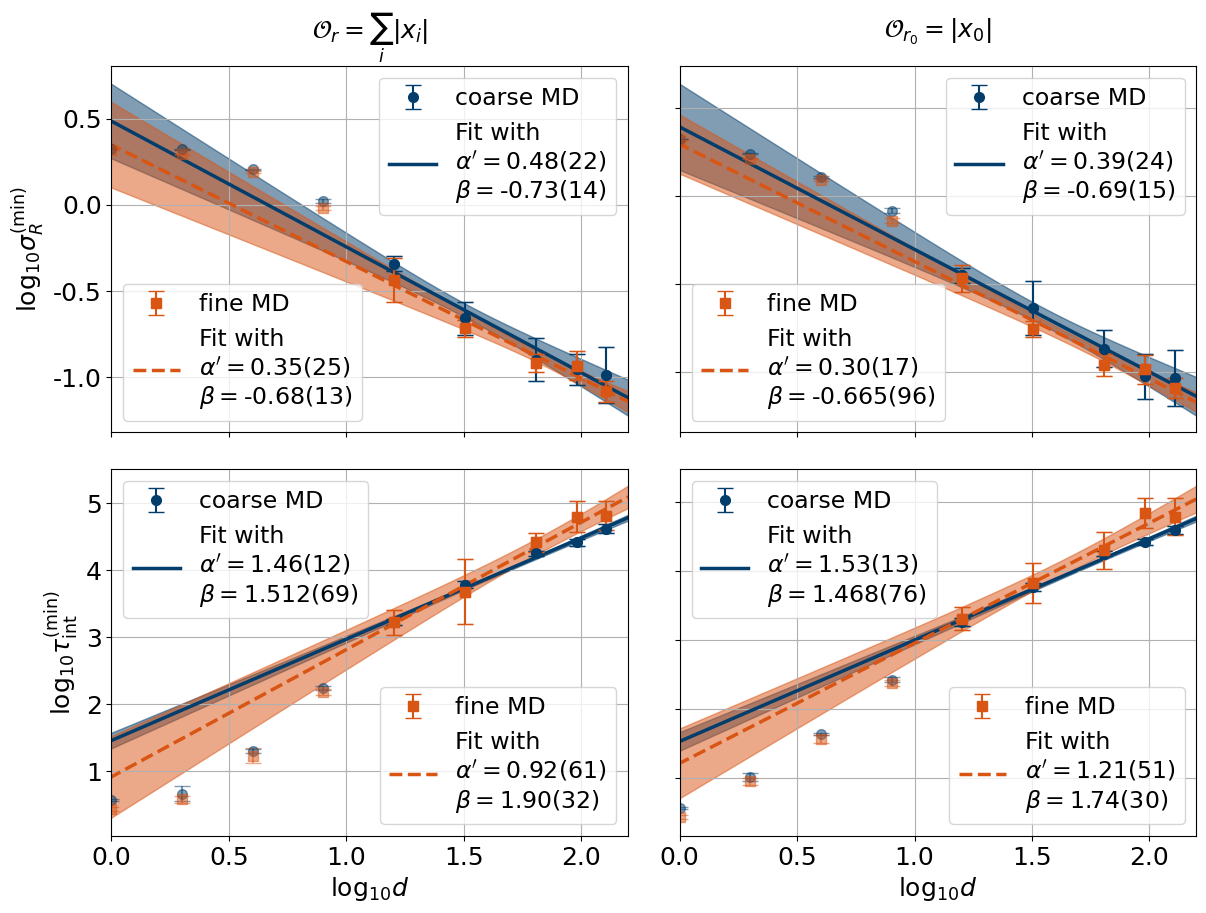

In [18]:
d_ = [1, 2, 4, 8, 16, 32, 64, 96, 128]

fs = 18
fs2 = 17
lw = 2.5
ms = 7
capsize = 6
opacity = 0.5
obs_title_names = [r"$\sum x_i$", r"$\mathcal{O}_r = \sum_i |x_i|$", r"$\sum x_i^2$", r"$x_0$", r"$\mathcal{O}_{r_0} = |x_0|$", r"$x_0^2$"]
obs_indices = (1, 4)

col_names = ["d", "smin", "smin_err", "tint_min", "tint_min_err"]
ac_criteria = ["S1"]

# cs = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
# marker_ = ["x", "s", "o", "v", "^", "P"]
marker_ = ["o", "o", "o", "s", "s", "s"]
cs_tmp = [cs[0], cs[0], cs[0], cs[1], cs[1], cs[1]]
ls = ["-", "-", "-", "--", "--", "--"]
cs_2_tmp = ["tab:green", "tab:green", "tab:green", "tab:brown", "tab:brown", "tab:brown"]

marker_ = ["o", "s"]

tmp_a = ["coarse", "fine"]

weight_fits = False
logfit = True

use_weighted_data = False

x_min = -0.01 if logfit else 0.5
x_max = 2.2 if logfit else 150
n_start_ = [4, 4, 4, 4]
n_stop_ = [None, None, None, None]
ylims_ = ([], [], [], [])
fig, ax = plt.subplots(2, 2, figsize = (14, 10), sharex = True, sharey = False)
for crit in ac_criteria:
    for ind2, ind in enumerate(obs_indices):
        cax = ax[0, ind2]
        for ind3, cf_name in enumerate(tmp_a):
            label = "coarse MD" if cf_name == "coarse" else "fine MD"
            linestyle = "-" if cf_name == "coarse" else "--"
            add_str1 = "_weighted" if use_weighted_data else ""
            csv_fname = postpro_path + "Rtoy_"+cf_name+"_smin_tintmin_"+obs_names_[ind]+"_"+crit+add_str1+".csv"
            df = pd.read_csv(csv_fname)
            data = df.to_numpy()
            
            d_, smin_, smin_err_, tintmin_, tintmin_err_ = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]
            n_start = n_start_[ind2]
            n_stop = n_stop_[ind2]
            if logfit:
                d_ = np.log10(d_)
                smin_err_ = np.divide(smin_err_, smin_*np.log(10))
                smin_ = np.log10(smin_)
            fit_f = logsmin_fit_f if logfit else smin_fit_f
            d_plot, mean, mean_err, popt, perr = bootstrap_fit(fit_f, d_[n_start:n_stop], smin_[n_start:n_stop], smin_err_[n_start:n_stop], n_bootstrap = 1000, weight_fits = weight_fits, seed = 1337, n_plot_points = 1000, x_min = x_min, x_max = x_max)
            
            val1, err1 = round_to_n_of_err(popt[0], perr[0], n = 2)
            val2, err2 = round_to_n_of_err(popt[1], perr[1], n = 2)
            cax.plot(d_plot, mean, linestyle = linestyle, linewidth = lw, color = cs[ind3], label = "Fit with\n"+r"$\alpha'=$"+get_parentheses_error_notation(val1, err1)+"\n"+r"$\beta=$"+get_parentheses_error_notation(val2, err2))
            cax.fill_between(d_plot, np.add(mean, mean_err), np.subtract(mean, mean_err), alpha = opacity, color = cs[ind3])
            
            cax.errorbar(d_, smin_, smin_err_, color = cs[ind3], alpha = opacity, linestyle = "", marker = marker_[ind3], markersize = ms, capsize = capsize)
            cax.errorbar(d_[n_start:n_stop], smin_[n_start:n_stop], smin_err_[n_start:n_stop], color = cs[ind3], linestyle = "", marker = marker_[ind3], markersize = ms, capsize = capsize, 
                             label = label)
            
            cax.grid(True)
            ax[0, 0].set_ylabel(r"$\log_{10} \sigma_R^{(\mathrm{min})}$", fontsize = fs)
        cax.grid(True)
        cax.set_title(obs_title_names[ind], fontsize = fs, pad = 20)
        
        handles, labels = cax.get_legend_handles_labels()
        tmp_handles = [handles[2], handles[0]]
        tmp_labels = [labels[2], labels[0]]
        legend1 = cax.legend(tmp_handles, tmp_labels, loc = "upper right", fontsize = fs2)
        cax.add_artist(legend1)
        tmp_handles = [handles[3], handles[1]]
        tmp_labels = [labels[3], labels[1]]
        cax.legend(tmp_handles, tmp_labels, loc = "lower left", fontsize = fs2)
        if not logfit:
            cax.set_yscale("log")
            cax.set_xscale("log")
        else:
            cax.set_xlim(0, 2.2)
            tmp = [0.5, 0.0, -0.5, -1.0]
            cax.set_yticks(tmp, labels = [str(x) for x in tmp] if ind2==0 else ["" for x in tmp], fontsize = fs)
        cax.tick_params(axis = "both", labelsize = fs)


for crit in ac_criteria:
    for ind2, ind in enumerate(obs_indices):
        cax = ax[1, ind2]
        for ind3, cf_name in enumerate(tmp_a):
            label = "coarse MD" if cf_name == "coarse" else "fine MD"
            linestyle = "-" if cf_name == "coarse" else "--"
            add_str1 = "_weighted" if use_weighted_data else ""
            csv_fname = postpro_path + "Rtoy_"+cf_name+"_smin_tintmin_"+obs_names_[ind]+"_"+crit+add_str1+".csv"
            df = pd.read_csv(csv_fname)
            data = df.to_numpy()
            
            d_, smin_, smin_err_, tintmin_, tintmin_err_ = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]
            if logfit:
                d_ = np.log10(d_)
                tintmin_err_ = np.divide(tintmin_err_, tintmin_)
                tintmin_ = np.log10(tintmin_)
            n_start = n_start_[ind2]
            n_stop = n_stop_[ind2]
            fit_f = logsmin_fit_f if logfit else smin_fit_f
            d_plot, mean, mean_err, popt, perr = bootstrap_fit(fit_f, d_[n_start:n_stop], tintmin_[n_start:n_stop], tintmin_err_[n_start:n_stop], n_bootstrap = 1000, weight_fits = weight_fits, seed = 1337, n_plot_points = 1000, x_min = x_min, x_max = x_max)

            val1, err1 = round_to_n_of_err(popt[0], perr[0], n = 2)
            val2, err2 = round_to_n_of_err(popt[1], perr[1], n = 2)
            cax.plot(d_plot, mean, linestyle = linestyle, linewidth = lw, color = cs[ind3], label = "Fit with\n"+r"$\alpha'=$"+get_parentheses_error_notation(val1, err1)+"\n"+r"$\beta=$"+get_parentheses_error_notation(val2, err2))
            cax.fill_between(d_plot, np.add(mean, mean_err), np.subtract(mean, mean_err), alpha = opacity, color = cs[ind3])
            
            cax.errorbar(d_, tintmin_, tintmin_err_, color = cs[ind3], alpha = opacity, linestyle = "", marker = marker_[ind3], markersize = ms, capsize = capsize)
            cax.errorbar(d_[n_start:n_stop], tintmin_[n_start:n_stop], tintmin_err_[n_start:n_stop], color = cs[ind3], linestyle = "", marker = marker_[ind3], markersize = ms, capsize = capsize, 
                             label = label)
            
            cax.grid(True)
            cax.set_xlabel(r"$\log_{10} d$", fontsize = fs)
            ax[1, 0].set_ylabel(r"$\log_{10} \tau_\mathrm{int}^{(\mathrm{min})}$", fontsize = fs)
        cax.grid(True)
        
        handles, labels = cax.get_legend_handles_labels()
        tmp_handles = [handles[2], handles[0]]
        tmp_labels = [labels[2], labels[0]]
        legend1 = cax.legend(tmp_handles, tmp_labels, loc = "upper left", fontsize = fs2)
        cax.add_artist(legend1)
        tmp_handles = [handles[3], handles[1]]
        tmp_labels = [labels[3], labels[1]]
        cax.legend(tmp_handles, tmp_labels, loc = "lower right", fontsize = fs2)
        if not logfit:
            cax.set_yscale("log")
            cax.set_xscale("log")
        else:
            cax.set_xlim(0, 2.2)
            tmp = [1, 2, 3, 4, 5]
            cax.set_yticks(tmp, labels = [str(x) for x in tmp] if ind2==0 else ["" for x in tmp], fontsize = fs)
        cax.tick_params(axis = "both", labelsize = fs)
        
    # fig.suptitle(crit, fontsize = fs)
    fig.subplots_adjust(wspace = 0.1, hspace = 0.1)
    # plt.savefig(plot_path + "Rtoy_wb0p125_scaling_HMCcomp_"+crit+"_reduced.pdf", dpi = 300, bbox_inches = "tight")
    plt.show()


# Region crossing rates  
Compute and plot the region crossing rates (tunneling rates) of the $x_0$ component as a function of dimensionality $d$.  
This will take some time, so feel free to rely on the already postprocessed data.

In [10]:
region_crossing_dict = {}

bins = [-9/2*np.pi, -7/2*np.pi, -5/2*np.pi, -3/2*np.pi, -1/2*np.pi, 1/2*np.pi, 3/2*np.pi, 5/2*np.pi, 7/2*np.pi, 9/2*np.pi]
labels = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
header = ["sigma", "region_crossing"]

nvals = None #int(1e2)
d_ = [1, 2, 4, 8, 16, 32, 64, 96, 128]

t1 = time.time()
print("Begin analysis for coarse MD integration")
for d in d_:
    t2 = time.time()
    NMD = coarse_dict[f"d{d}"]["NMD"]
    tMD = coarse_dict[f"d{d}"]["tMD"]
    sig_ = coarse_dict[f"d{d}"]["sig"]
    nrc = np.zeros(len(sig_))
    for i, sig in enumerate(sig_):
        nrc[i], _ = get_tunneling_rate(fname = data_path + f"d{d}/Rtoy_b0p125_d{d}_s"+str(sig).replace(".", "p")+f"_NMD{NMD}_tMD{tMD}.txt", bins = bins, labels = labels, nvals = nvals)
    save_path = postpro_path + f"d{d}/Rtoy_d{d}_tunnel_rate_coarse.txt"
    save_arrays(save_path, header, False, sig_, nrc)
    print(f"{d=} done after {round(time.time()-t2, 4)}. Full time elapsed since beginning: {round(time.time()-t1, 4)}")
    
print("Begin analysis for fine MD integration")
for d in d_:
    t2 = time.time()
    NMD = fine_dict[f"d{d}"]["NMD"]
    tMD = fine_dict[f"d{d}"]["tMD"]
    sig_ = fine_dict[f"d{d}"]["sig"]
    nrc = np.zeros(len(sig_))
    for i, sig in enumerate(sig_):
        nrc[i], _ = get_tunneling_rate(fname = data_path + f"d{d}/Rtoy_b0p125_d{d}_s"+str(sig).replace(".", "p")+f"_NMD{NMD}_tMD{tMD}.txt", bins = bins, labels = labels, nvals = nvals)
    save_path = postpro_path + f"d{d}/Rtoy_d{d}_tunnel_rate_fine.txt"
    save_arrays(save_path, header, False, sig_, nrc)
    print(f"{d=} done after {round(time.time()-t2, 4)}. Full time elapsed since beginning: {round(time.time()-t1, 4)}")

    

Begin analysis for coarse MD integration
d=1 done after 65.0628. Full time elapsed since beginning: 65.0632
d=2 done after 66.8738. Full time elapsed since beginning: 131.9371
d=4 done after 58.8139. Full time elapsed since beginning: 190.7511
d=8 done after 58.4005. Full time elapsed since beginning: 249.1518
d=16 done after 48.1052. Full time elapsed since beginning: 297.2571
d=32 done after 60.4863. Full time elapsed since beginning: 357.7436
d=64 done after 657.757. Full time elapsed since beginning: 1015.5008
d=96 done after 497.9413. Full time elapsed since beginning: 1513.4422
d=128 done after 397.3384. Full time elapsed since beginning: 1910.7807
Begin analysis for fine MD integration
d=1 done after 66.5733. Full time elapsed since beginning: 1977.3547
d=2 done after 66.993. Full time elapsed since beginning: 2044.3477
d=4 done after 58.3122. Full time elapsed since beginning: 2102.66
d=8 done after 58.2817. Full time elapsed since beginning: 2160.9418
d=16 done after 56.1379. 

## Make the actual plot

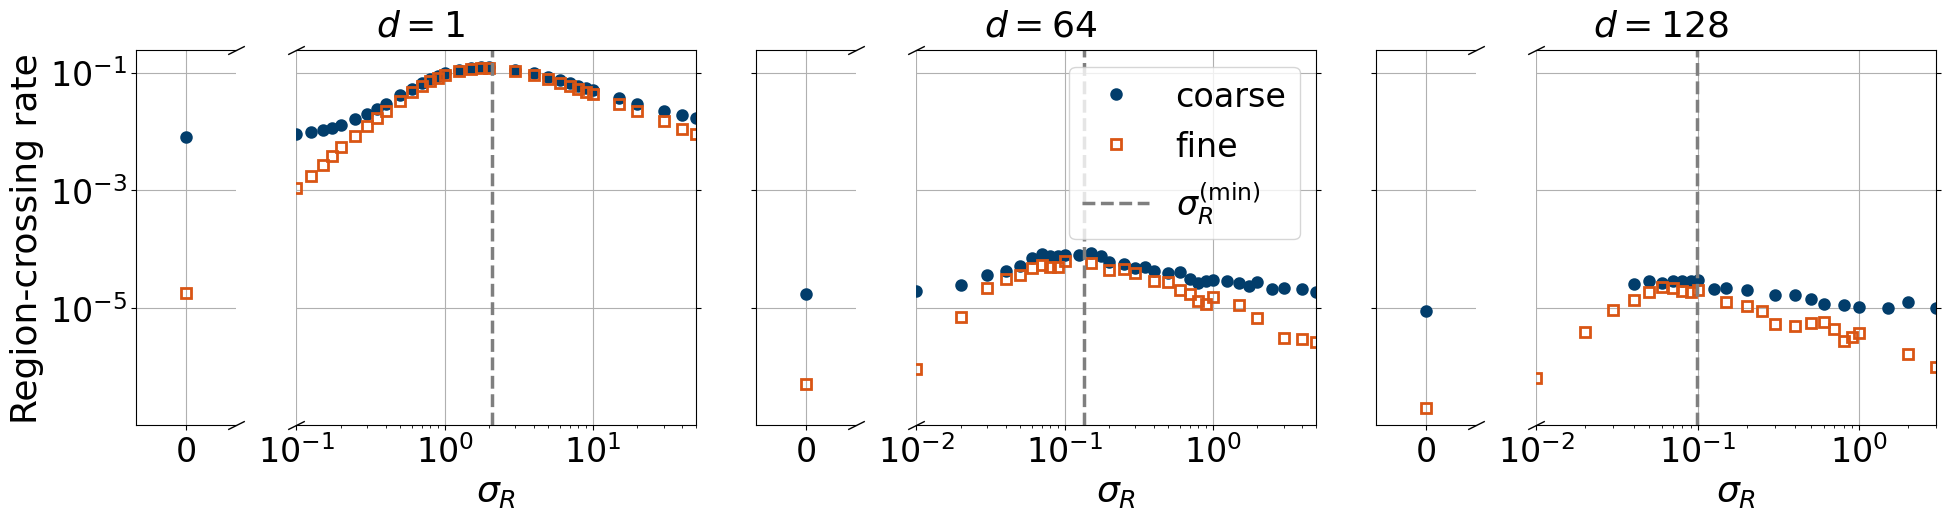

In [8]:
fig, ax = plt.subplots(1, 6, figsize = (20, 15), sharey = True)
ax = np.reshape(ax, (1, 6))

gap = 0.03
wspace = 0.03
plt_w_left = 0.05
plt_w_right = 0.2

fs = 24
fs2 = 24
fs3 = 26
ms = 7

obs_indices = (0, 1, 3, 4)
obs_names = ["mean", "absmean", "radius", "mean_x0", "absmean_x0", "radius_x0"]
tmp_a = ["coarse", "fine"]
marker_ = ["o", "s"]

i = 0
for j2, d in enumerate([1, 64, 128]):
    j = j2*2
    # Compute observable averaged s_min; Maybe change this to weighted sum
    avg_smin = 0
    counter = 0
    for cf_name in tmp_a:
        for obs_ind in obs_indices:
            csv_fname = postpro_path + "Rtoy_"+cf_name+"_smin_tintmin_"+obs_names[obs_ind]+"_S1.csv"
            df = pd.read_csv(csv_fname)
            data = df.to_numpy()
            d2_, smin_, smin_err_ = data[:, 0], data[:, 1], data[:, 2]
            d_ind = np.argwhere(d2_==d).item()
            avg_smin += smin_[d_ind]
            counter+=1
            ### weighted sum
            # avg_smin += smin_[d_ind]/smin_err_[d_ind]**2
            # counter+=1/smin_err_[d_ind]**2
    avg_smin /= counter
    # print(avg_smin)

    ax[i, j+0].set_position([0.1+j2*(plt_w_left+plt_w_right+gap+wspace), 0.05+(2-i)*0.3, plt_w_left, 0.25])
    ax[i, j+1].set_position([0.1+plt_w_left+gap+j2*(plt_w_left+plt_w_right+gap+wspace), 0.05+(2-i)*0.3, plt_w_right, 0.25])

    # ax[i, j+1].plot([0.01], [0.4], color = "white", marker = "", linestyle = "", label = f"d={d}")

    xmin, xmax = 100, 0
    for MD_ind, MD_int in enumerate(tmp_a):
        fillstyle = "full" if MD_ind == 0 else "none"
        sig_, nrc_ = np.loadtxt(postpro_path + f"d{d}/Rtoy_d{d}_tunnel_rate_"+MD_int+".txt", usecols = (0, 1), skiprows = 1, unpack = True)
        ax[i, j+0].plot(sig_, nrc_, marker = marker_[MD_ind], markersize = ms, fillstyle = fillstyle, mew = 2, linestyle = "", color = cs[MD_ind], label = MD_int)
        ax[i, j+1].plot(sig_, nrc_, marker = marker_[MD_ind], markersize = ms, fillstyle = fillstyle, mew = 2, linestyle = "", color = cs[MD_ind], label = MD_int)
        xmin, xmax = min(xmin, min(sig_[1:])), max(xmax, max(sig_))

    # sig_, nrc_ = np.loadtxt(postpro_path + f"d{d}/Rtoy_d{d}_tunnel_rate_coarse.txt", usecols = (0, 1), skiprows = 1, unpack = True)
    # ax[i, j+0].plot(sig_, nrc_, marker = "o", linestyle = "", color = cs[0], label = "coarse")
    # ax[i, j+1].plot(sig_, nrc_, marker = "o", linestyle = "", color = cs[0], label = "coarse")

    ax[i, j+1].axvline(avg_smin, color = "tab:grey", linestyle = "--", linewidth = 2.5, label = r"$\sigma_R^{(\mathrm{min})}$")

    handles, labels = ax[i, j+1].get_legend_handles_labels()
    # handles_tmp = [handles[0], handles[1], handles[2], handles[3]]
    # labels_tmp = [labels[0], labels[1], labels[2], labels[3]]
    if j == 2:
        handles_tmp = [handles[0], handles[1], handles[2]]
        labels_tmp = [labels[0], labels[1], labels[2]]
        ax[i, j+1].legend(handles = handles_tmp, labels = labels_tmp, loc = "lower right" if d==1 else "upper right", fontsize = fs2)

    ax[i, j+0].set_xlim(-0.0001, 0.0001)
    ax[i, j+1].set_xscale("log")
    ax[i, j+0].set_yscale("log")
    ax[i, j+1].set_yscale("log")
    ax[i, j+1].set_xlim(xmin, xmax)
    ax[i, j+0].set_xticks([0])
    ax[i, j+0].grid()
    ax[i, j+1].grid()
    ax[i, j].tick_params(axis='x', labelsize=fs), ax[i, j].tick_params(axis='y', labelsize=fs)
    ax[i, j+1].tick_params(axis='x', labelsize=fs), ax[i, j+1].tick_params(axis='y', labelsize=fs)
    # ax[i, j+0].sharey(ax[i, j+1])

    ax[i, j+0].spines.right.set_visible(False)
    ax[i, j+1].spines.left.set_visible(False)
    ax[i, j+1].yaxis.tick_right()
    ax[i, j+1].tick_params(labelright=False)
    ax[i, 0].set_ylabel("Region-crossing rate", fontsize = fs3)
    ax[i, j+1].set_xlabel(r"$\sigma_R$", fontsize = fs3)
    d_val = .5
    kwargs = dict(marker=[(-1, -d_val), (1, d_val)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax[i, j+0].plot([1, 1], [0, 1], transform=ax[i, j+0].transAxes, **kwargs)
    ax[i, j+1].plot([0, 0], [0, 1], transform=ax[i, j+1].transAxes, **kwargs)
    ax[i, j+1].set_title(r"$d=$"+f"{d}", fontsize = fs3, x = 0.31, pad = 10)
# plt.savefig(plot_path + "Rtoy_region_crossing_rate_wb0p125_small.pdf", dpi = 400, bbox_inches = "tight")
plt.show()
